In [1]:
import dgl
import torch

graph = dgl.load_graphs('/root/social_computing_group/dgl_graph.bin')[0][0]

print("number of nodes:", graph.number_of_nodes())
print("number of edges:", graph.number_of_edges())
print("feature:", graph.ndata['feature'].shape)
print("lable:", torch.unique(graph.ndata['label'], return_counts=True))

number of nodes: 7624
number of edges: 55612
feature: torch.Size([7624, 7842])
lable: (tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]), tensor([1098,   54,   73,  515,   16,  391,  655,   82,  468,   58, 1303,  138,
          57,   63,  570,  257,  254, 1572]))


In [2]:
def split_masks(graph, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, seed=42):
    torch.manual_seed(seed)
    labels = graph.ndata['label']
    num_nodes = graph.num_nodes()

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    num_classes = len(torch.unique(labels))

    for c in range(num_classes):
        idx = (labels == c).nonzero(as_tuple=True)[0]
        idx = idx[torch.randperm(len(idx))]

        n_train = int(len(idx) * train_ratio)
        n_val = int(len(idx) * val_ratio)

        train_mask[idx[:n_train]] = True
        val_mask[idx[n_train:n_train + n_val]] = True
        test_mask[idx[n_train + n_val:]] = True

    graph.ndata['train_mask'] = train_mask
    graph.ndata['val_mask'] = val_mask
    graph.ndata['test_mask'] = test_mask

    print("number of train：", train_mask.sum().item())
    print("number of valid：", val_mask.sum().item())
    print("number of test：", test_mask.sum().item())

split_masks(graph)

number of train： 4566
number of valid： 1517
number of test： 1541


In [3]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv

#定义模型
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats, aggregator_type='mean')
        self.conv2 = SAGEConv(hidden_feats, num_classes, aggregator_type='mean')
        self.dropout = nn.Dropout(0.5)  #增加Dropout层

    def forward(self, g, x):
        x = self.conv1(g, x)
        x = F.relu(x)
        x = self.dropout(x) 
        x = self.conv2(g, x)
        return x

In [4]:
features = graph.ndata['feature']
labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
val_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']

# 模型初始化
in_feats = features.shape[1]
hidden_feats = 64
num_classes = int(labels.max().item() + 1)

model = GraphSAGE(in_feats, hidden_feats, num_classes)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [5]:
#创建log
import sys
import os
from datetime import datetime

log_dir = "classification_log"
os.makedirs(log_dir, exist_ok=True)

log_filename = datetime.now().strftime(f"{log_dir}/classification_log_%Y%m%d_%H%M%S.txt")

class Logger(object):
    def __init__(self, filename):
        self.terminal = sys.stdout
        self.log = open(filename, "w", encoding="utf-8")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def flush(self):
        self.terminal.flush()
        self.log.flush()

sys.stdout = Logger(log_filename)

[Epoch 1] Loss: 3.4735, Train Acc: 0.0602, Val Acc: 0.0541, Val F1: 0.0292
[Epoch 50] Loss: 0.5066, Train Acc: 0.8362, Val Acc: 0.7871, Val F1: 0.5036
[Epoch 100] Loss: 0.2215, Train Acc: 0.9262, Val Acc: 0.8194, Val F1: 0.6492
[Epoch 150] Loss: 0.1509, Train Acc: 0.9468, Val Acc: 0.8312, Val F1: 0.6906
[Epoch 200] Loss: 0.1163, Train Acc: 0.9577, Val Acc: 0.8207, Val F1: 0.6721
[Epoch 250] Loss: 0.0966, Train Acc: 0.9643, Val Acc: 0.8438, Val F1: 0.7146
[Epoch 300] Loss: 0.0873, Train Acc: 0.9658, Val Acc: 0.8385, Val F1: 0.7046
[Epoch 350] Loss: 0.0770, Train Acc: 0.9713, Val Acc: 0.8332, Val F1: 0.7181
[Epoch 400] Loss: 0.0803, Train Acc: 0.9711, Val Acc: 0.8299, Val F1: 0.7005

 acc: 0.8559
F1 Score: 0.7299

 classification report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       221
           1       1.00      0.33      0.50        12
           2       1.00      0.62      0.77        16
           3       0.90      0.92    

/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


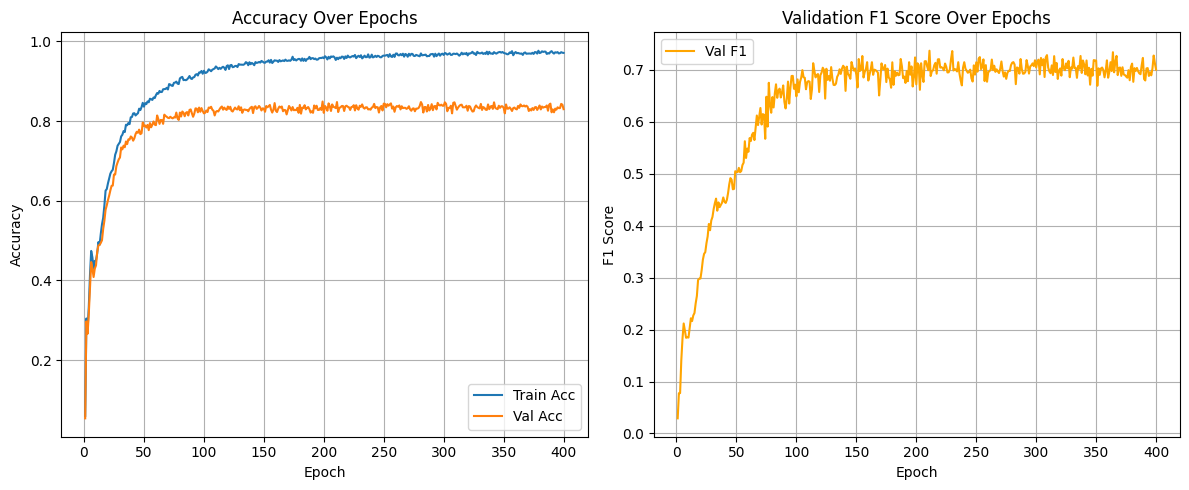

In [6]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

train_acc_list = []
val_acc_list = []
val_f1_list = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
features = features.to(device)
labels = labels.to(device)
train_mask = train_mask.to(device)
val_mask = val_mask.to(device)
test_mask = test_mask.to(device)
graph = graph.to(device)

#训练
best_val_acc = 0
best_model_state = None

for epoch in range(1, 401):
    model.train()
    logits = model(graph, features)
    loss = loss_fn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 评估
    model.eval()
    with torch.no_grad():
        pred = logits.argmax(dim=1)
        train_acc = accuracy_score(labels[train_mask].cpu(), pred[train_mask].cpu())
        val_acc = accuracy_score(labels[val_mask].cpu(), pred[val_mask].cpu())
        val_f1 = f1_score(labels[val_mask].cpu(), pred[val_mask].cpu(), average='macro')

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        val_f1_list.append(val_f1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    if epoch % 50 == 0 or epoch == 1:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

model.load_state_dict(best_model_state)

# 在测试集上评估
model.eval()
with torch.no_grad():
    logits = model(graph, features)
    pred = logits.argmax(dim=1)

    test_acc = accuracy_score(labels[test_mask].cpu(), pred[test_mask].cpu())
    test_f1 = f1_score(labels[test_mask].cpu(), pred[test_mask].cpu(), average='macro')
    print(f"\n acc: {test_acc:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print("\n classification report:")
    print(classification_report(labels[test_mask].cpu(), pred[test_mask].cpu()))

    # # 混淆矩阵
    # conf_matrix = confusion_matrix(labels[test_mask].cpu(), pred[test_mask].cpu())
    # plt.figure(figsize=(10, 7))
    # plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    # plt.title("confusion matrix")
    # plt.colorbar()
    # tick_marks = range(num_classes)
    # plt.xticks(tick_marks, tick_marks)
    # plt.yticks(tick_marks, tick_marks)
    # plt.xlabel('predict label')
    # plt.ylabel('real label')

epochs = list(range(1, 401))
plt.figure(figsize=(12, 5))

# 准确率曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_list, label='Train Acc')
plt.plot(epochs, val_acc_list, label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("Accuracy_image.png", dpi=300)

# F1 分数曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, val_f1_list, label='Val F1', color='orange')
plt.title("Validation F1 Score Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("F1_Score_image.png", dpi=300)
plt.show()

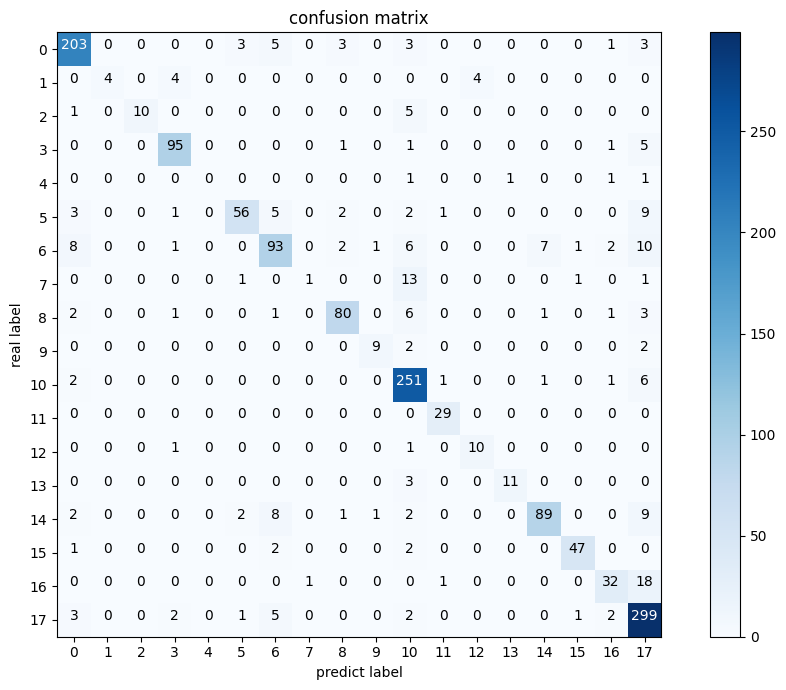

In [7]:
# 混淆矩阵
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(labels[test_mask].cpu(), pred[test_mask].cpu())

plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("confusion matrix")
plt.colorbar()
tick_marks = range(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('predict label')
plt.ylabel('real label')

thresh = conf_matrix.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig("confusion_matrix_image.png", dpi=300)
plt.show()

In [8]:
# 每个类别的样本数量
train_labels = labels[train_mask].cpu().numpy()
unique, counts = np.unique(train_labels, return_counts=True)
print(f"number of each class: {dict(zip(unique, counts))}")

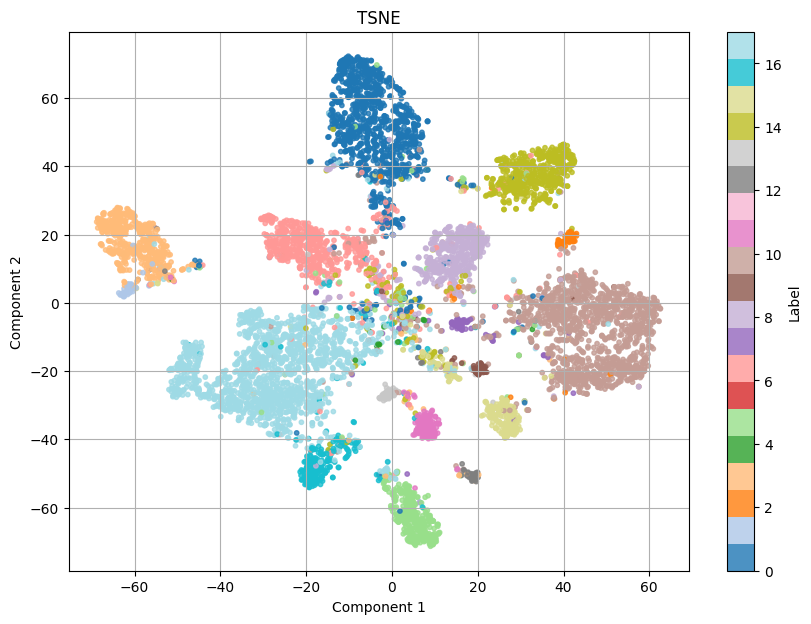

In [9]:
#可视化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class EmbeddingExtractor(nn.Module):
    def __init__(self, gnn_model):
        super().__init__()
        self.gnn_model = gnn_model

    def forward(self, g, x):
        x = self.gnn_model.conv1(g, x)
        x = F.relu(x)
        return x

extractor = EmbeddingExtractor(model).to(device)
model.eval()
with torch.no_grad():
    embeddings = extractor(graph, features).cpu().numpy()
    labels_np = labels.cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=50)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_np, cmap='tab20', s=10, alpha=0.8)
plt.title("TSNE")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, label="Label")
plt.grid(True)
plt.savefig("TSNE_image.png", dpi=300)
plt.show()